# Analyse glove wearing of people handling bats

Uses logistic regression to model the probability that someone was using gloves with date as the independent variable

In [1]:
# To read the CSV file of input data
#install.packages("readr") #uncomment if not already installed
library(readr) 


Warning message:
"package 'readr' was built under R version 3.6.3"

In [2]:
# For plotting the results
#install.packages("ggplot2") #uncomment if not already installed
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

In [3]:
# To use a fancy theme in plotting with ggplot
#install.packages("ggthemes") #uncomment if not already installed
library(ggthemes)

Warning message:
"package 'ggthemes' was built under R version 3.6.3"

In [4]:
# To filter and reformat data
#install.packages("dplyr") #uncomment if not already installed
library(dplyr)



Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [5]:
# Widen the data
#install.packages("reshape2") #uncomment if not already installed
library(reshape2)


Warning message:
"package 'reshape2' was built under R version 3.6.3"

In [6]:
# To access the iNaturalist API
#install.packages("rinat") #uncomment if not already installed
library(rinat)


Warning message:
"package 'rinat' was built under R version 3.6.3"

In [7]:
# To parse the iNaturalist URL
#install.packages("httr") #uncomment if not already installed
library(httr)

Warning message:
"package 'httr' was built under R version 3.6.3"

## Read in the input as a CSV file

In [101]:
handsglovesbats <- read.csv("~/R/gloves/handsglovesbats.csv")

In [102]:
## This section converts the words 'gloves' and 'hands' to a binary 1 and 0
handsglovesbats$gloveOrHand <- as.factor(handsglovesbats$gloveOrHand )
handsglovesbats$gloveOrHand <- as.numeric(handsglovesbats$gloveOrHand)
handsglovesbats$gloveOrHand <- handsglovesbats$gloveOrHand -2
handsglovesbats$gloveOrHand <- handsglovesbats$gloveOrHand *-1

In [103]:
# Get rid of years before 2008, because there is little data
#handsglovesbats <- handsglovesbats[handsglovesbats$year > 2007, ]   

## Loop over the input collecting additional data from the iNaturalist API

In [104]:


if(file.exists("dataExtractedFromINAT.csv")){
    print("The data has already been extracted")
    handsglovesbats <- read.csv("dataExtractedFromINAT.csv")
} else {
    for (row in 1:nrow(handsglovesbats)) {
  
        path <- parse_url(handsglovesbats[row,"observation"])$path

        iNaturalistID <- strsplit(path, "/")[[1]][2]

        handsglovesbats[row, "iNaturalistID"]   <- iNaturalistID

        #########################################################################
        # BEWARE THIS CALLS THE iNATURALIST API AND SO SHOULD BE USE CAUTIOUSLY #
        #########################################################################
        observation <- get_inat_obs_id(iNaturalistID)
        
        Sys.sleep(2) # Slow it down so that the API is not overloaded
        
        # Don't collect data for observations that are not licensed
        if(!is.null(observation$license)){
            handsglovesbats[row, "observed_on"] <- observation$observed_on
            if(is.null(observation$observation$latitude)){
                handsglovesbats[row, "latitude"] <- 999
                handsglovesbats[row, "longitude"] <- 999
            } else {
                handsglovesbats[row, "latitude"] <- observation$latitude
                handsglovesbats[row, "longitude"] <- observation$longitude
            }

            if(is.null(observation$positional_accuracy)){
                handsglovesbats[row, "positional_accuracy"] <- 0
            } else {
                handsglovesbats[row, "positional_accuracy"] <- observation$positional_accuracy
            }
            handsglovesbats[row, "quality_grade"] <- observation$quality_grade
            handsglovesbats[row, "license"] <- observation$license
            handsglovesbats[row, "captive"] <- observation$captive
            #if no consensus identification has been made the community_taxon_id will be NULL
            if(is.null(observation$community_taxon_id)){ 
                handsglovesbats[row, "taxon_id"] <- observation$taxon_id
            } else {
                handsglovesbats[row, "taxon_id"] <- observation$community_taxon_id
            }
            handsglovesbats[row, "recorded_by"] <- observation$user$login
        }
    }
}

[1] "The data has already been extracted"


## Output the retrived data to a CSV file for storage

In [105]:
if(!file.exists("dataExtractedFromINAT.csv")){
    write.csv(handsglovesbats,"dataExtractedFromINAT.csv")
    }

## Remove the rows where the data are not licenced

In [106]:
handsglovesbats <- handsglovesbats[complete.cases(handsglovesbats[5:5]),]

## Convert the data in text to a real date type

In [107]:
handsglovesbats$observed_on <- as.Date(handsglovesbats$observed_on)

In [108]:
#handsglovesbats$gloveOrHand <- ordered(handsglovesbats$gloveOrHand, levels = c("hand", "glove"))

#levels(handsglovesbats$gloveOrHand) <- c(0,1)

## Create the model

In [109]:
modelLG <- glm(gloveOrHand ~ observed_on,family=binomial(link='logit'),data=handsglovesbats)

summary(modelLG)


Call:
glm(formula = gloveOrHand ~ observed_on, family = binomial(link = "logit"), 
    data = handsglovesbats)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2250  -1.0707  -0.8183   1.1568   2.3247  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.701e+00  1.195e+00  -5.609 2.03e-08 ***
observed_on  3.653e-04  6.782e-05   5.386 7.21e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 963.24  on 706  degrees of freedom
Residual deviance: 930.18  on 705  degrees of freedom
  (89 observations deleted due to missingness)
AIC: 934.18

Number of Fisher Scoring iterations: 4


In [110]:
# Odds Ratio
oddrat <- exp(coef(modelLG))
oddrat

anova(modelLG, test="Chisq")

(Intercept) observed_on 
0.001229879 1.000365324

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,706,963.2381,NA
observed_on,1,33.06123,705,930.1769,8.930175e-09


## Display the results in a graph

Warning message:
"Ignoring unknown parameters: height, width"Warning message:
"Removed 89 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 89 rows containing missing values (geom_point)."

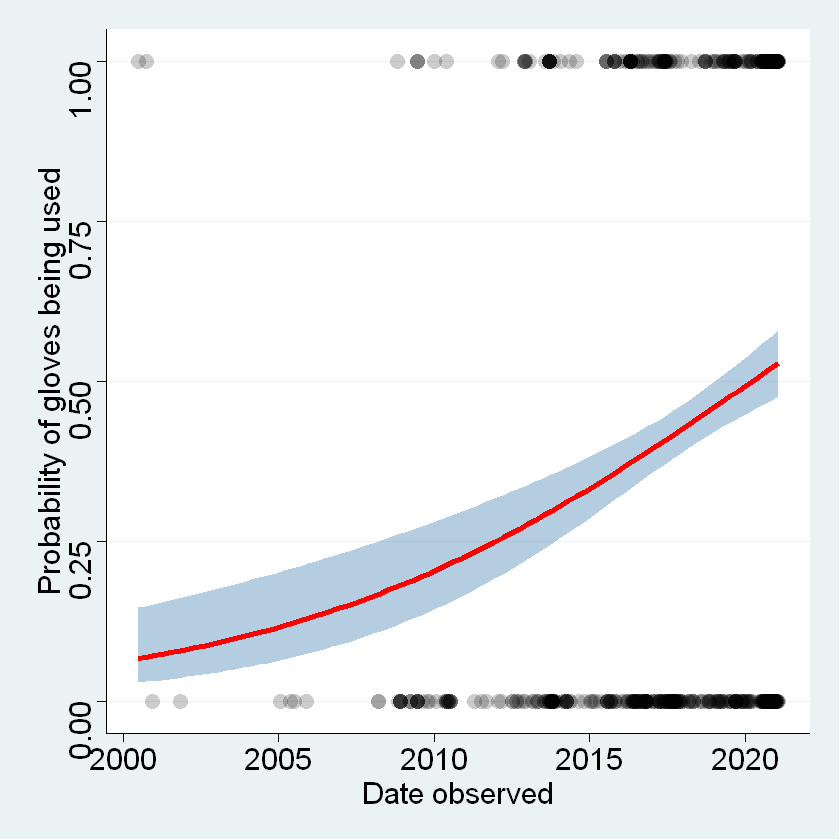

In [111]:
ggplot(handsglovesbats, aes(x=observed_on, y=gloveOrHand)) + 
  geom_point(height = 0.03, width=0.3, shape=16, alpha = 0.2, size=4) +
  #geom_jitter(height = 0.03, width=0.3, shape=1, alpha = 0.4) +
  #scale_x_continuous(breaks = seq(2008, 2021, by = 3)) +
  stat_smooth(formula = y ~ x, method="glm", method.args=list(family="binomial"), se=TRUE, fill = "steelblue", inherit.aes = TRUE, size = 1.5, linetype = 1, colour = "red") +
  labs(y = "Probability of gloves being used", x = "Date observed") + theme_stata(base_size = 20, base_family = "sans", scheme = "s2color")

## Output the plot as high quality files

In [112]:
ggsave(
  "gloveprobability.tiff",
  plot = last_plot(),
  device = "tiff",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

ggsave(
  "gloveprobability.jpg",
  plot = last_plot(),
  device = "jpg",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

Warning message:
"Removed 89 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 89 rows containing missing values (geom_point)."Warning message:
"Removed 89 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 89 rows containing missing values (geom_point)."

## See where the observations come from

In [113]:
handsglovesbats$longitude[handsglovesbats$longitude == 999] <- NA
handsglovesbats$latitude[handsglovesbats$latitude == 999] <- NA

handsglovesbats$longitude <- as.numeric(handsglovesbats$longitude)
handsglovesbats$latitude <- as.numeric(handsglovesbats$latitude)

handsglovesbats$gloveOrHand <- as.factor(handsglovesbats$gloveOrHand )

Warning message:
"Removed 703 rows containing missing values (geom_point)."

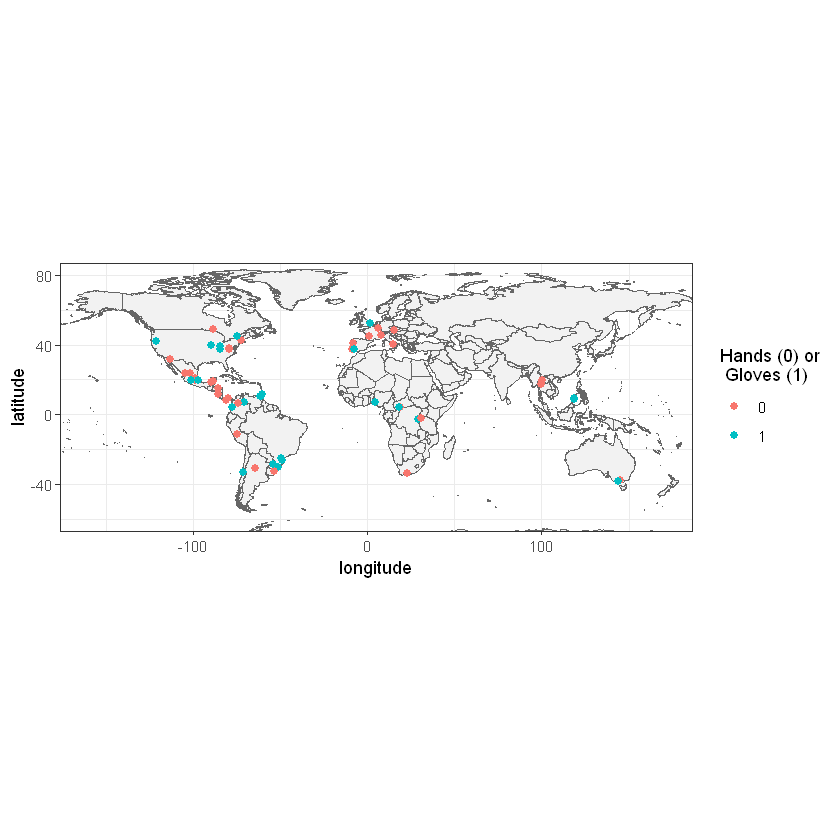

In [114]:
## A more elaborate map of Colibri sp.
ggplot(data = handsglovesbats, aes(x = longitude,
                             y = latitude,
                             colour = gloveOrHand)) +
      geom_polygon(data = map_data("world"),
                       aes(x = long, y = lat, group = group),
                       fill = "grey95",
                       color = "gray40",
                       size = 0.1) +
      geom_point(size = 2, alpha = 1) +
      #coord_fixed(xlim = range(handsglovesbats$longitude, na.rm = TRUE),
      #            ylim = range(handsglovesbats$latitude, na.rm = TRUE)) +
        coord_fixed(ylim = c(-60,80),
                  xlim = c(-160,170)) +
        labs(color = "Hands (0) or\n Gloves (1)") +
        theme_bw()

In [115]:
ggsave(
  "glovemap.tiff",
  plot = last_plot(),
  device = "tiff",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

ggsave(
  "glovemap.jpg",
  plot = last_plot(),
  device = "jpg",
  scale = 1,
  width = 242.7,
  height = 150,
  units = c("mm"),
  dpi = 300
)

Warning message:
"Removed 703 rows containing missing values (geom_point)."Warning message:
"Removed 703 rows containing missing values (geom_point)."